In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self , model):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.dr_layer1=nn.modules.conv.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn1=nn.modules.batchnorm.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer2=nn.modules.conv.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn2=nn.modules.batchnorm.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer3=nn.modules.conv.Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn3=nn.modules.batchnorm.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer4=nn.modules.conv.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

        
    def forward(self, x):
        x = self.resnet_layer(x)
        x=self.dr_layer1(x)
        x=self.dr_bn1(x)
        x=self.dr_layer2(x)
        x=self.dr_bn2(x)
        x=self.dr_layer3(x)
        x=self.dr_bn3(x)
        x=self.dr_layer4(x)
        return x

In [3]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1=nn.modules.conv.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = Net(resnet50) 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness12_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
 
        torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/500


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 0.4918, MAE: 0.5699, 
Validation: Loss: 5.1515, MAE: 2.2048, 
Time: 0.9340s
Best Error for validation : 2.2048 at epoch 001
Epoch: 2/500
Training: Loss: 0.3215, MAE: 0.5011, 
Validation: Loss: 4.4251, MAE: 1.9752, 
Time: 0.6680s
Best Error for validation : 1.9752 at epoch 002
Epoch: 3/500
Training: Loss: 0.3100, MAE: 0.4952, 
Validation: Loss: 3.4115, MAE: 1.7429, 
Time: 0.7051s
Best Error for validation : 1.7429 at epoch 003
Epoch: 4/500
Training: Loss: 0.3024, MAE: 0.4941, 
Validation: Loss: 2.3038, MAE: 1.4577, 
Time: 0.6251s
Best Error for validation : 1.4577 at epoch 004
Epoch: 5/500
Training: Loss: 0.2927, MAE: 0.4903, 
Validation: Loss: 1.3781, MAE: 1.1327, 
Time: 0.6734s
Best Error for validation : 1.1327 at epoch 005
Epoch: 6/500
Training: Loss: 0.2863, MAE: 0.4884, 
Validation: Loss: 0.8164, MAE: 0.8650, 
Time: 0.6318s
Best Error for validation : 0.8650 at epoch 006
Epoch: 7/500
Training: Loss: 0.2743, MAE: 0.4815, 
Validation: Loss: 0.5983, MAE: 0.7305, 
Time

Epoch: 55/500
Training: Loss: 0.0416, MAE: 0.2017, 
Validation: Loss: 0.0840, MAE: 0.2436, 
Time: 0.6246s
Best Error for validation : 0.2436 at epoch 055
Epoch: 56/500
Training: Loss: 0.0386, MAE: 0.1942, 
Validation: Loss: 0.0758, MAE: 0.2303, 
Time: 0.6374s
Best Error for validation : 0.2303 at epoch 056
Epoch: 57/500
Training: Loss: 0.0345, MAE: 0.1832, 
Validation: Loss: 0.0753, MAE: 0.2274, 
Time: 0.6537s
Best Error for validation : 0.2274 at epoch 057
Epoch: 58/500
Training: Loss: 0.0318, MAE: 0.1760, 
Validation: Loss: 0.0706, MAE: 0.2202, 
Time: 0.6579s
Best Error for validation : 0.2202 at epoch 058
Epoch: 59/500
Training: Loss: 0.0288, MAE: 0.1668, 
Validation: Loss: 0.0673, MAE: 0.2135, 
Time: 0.6651s
Best Error for validation : 0.2135 at epoch 059
Epoch: 60/500
Training: Loss: 0.0257, MAE: 0.1588, 
Validation: Loss: 0.0638, MAE: 0.2056, 
Time: 0.6232s
Best Error for validation : 0.2056 at epoch 060
Epoch: 61/500
Training: Loss: 0.0230, MAE: 0.1496, 
Validation: Loss: 0.0611

Epoch: 109/500
Training: Loss: 0.0003, MAE: 0.0129, 
Validation: Loss: 0.0401, MAE: 0.1511, 
Time: 1.0888s
Best Error for validation : 0.1511 at epoch 103
Epoch: 110/500
Training: Loss: 0.0002, MAE: 0.0102, 
Validation: Loss: 0.0403, MAE: 0.1516, 
Time: 0.6377s
Best Error for validation : 0.1511 at epoch 103
Epoch: 111/500
Training: Loss: 0.0004, MAE: 0.0147, 
Validation: Loss: 0.0402, MAE: 0.1513, 
Time: 1.0916s
Best Error for validation : 0.1511 at epoch 103
Epoch: 112/500
Training: Loss: 0.0003, MAE: 0.0130, 
Validation: Loss: 0.0403, MAE: 0.1525, 
Time: 1.1047s
Best Error for validation : 0.1511 at epoch 103
Epoch: 113/500
Training: Loss: 0.0003, MAE: 0.0137, 
Validation: Loss: 0.0404, MAE: 0.1523, 
Time: 0.6944s
Best Error for validation : 0.1511 at epoch 103
Epoch: 114/500
Training: Loss: 0.0004, MAE: 0.0146, 
Validation: Loss: 0.0408, MAE: 0.1535, 
Time: 0.7499s
Best Error for validation : 0.1511 at epoch 103
Epoch: 115/500
Training: Loss: 0.0003, MAE: 0.0128, 
Validation: Loss:

Epoch: 162/500
Training: Loss: 0.0003, MAE: 0.0124, 
Validation: Loss: 0.0403, MAE: 0.1513, 
Time: 0.6234s
Best Error for validation : 0.1504 at epoch 160
Epoch: 163/500
Training: Loss: 0.0003, MAE: 0.0119, 
Validation: Loss: 0.0403, MAE: 0.1517, 
Time: 0.7104s
Best Error for validation : 0.1504 at epoch 160
Epoch: 164/500
Training: Loss: 0.0003, MAE: 0.0133, 
Validation: Loss: 0.0399, MAE: 0.1509, 
Time: 0.9939s
Best Error for validation : 0.1504 at epoch 160
Epoch: 165/500
Training: Loss: 0.0002, MAE: 0.0105, 
Validation: Loss: 0.0402, MAE: 0.1517, 
Time: 0.6278s
Best Error for validation : 0.1504 at epoch 160
Epoch: 166/500
Training: Loss: 0.0004, MAE: 0.0142, 
Validation: Loss: 0.0401, MAE: 0.1509, 
Time: 1.0521s
Best Error for validation : 0.1504 at epoch 160
Epoch: 167/500
Training: Loss: 0.0002, MAE: 0.0125, 
Validation: Loss: 0.0400, MAE: 0.1520, 
Time: 0.7844s
Best Error for validation : 0.1504 at epoch 160
Epoch: 168/500
Training: Loss: 0.0002, MAE: 0.0119, 
Validation: Loss:

Epoch: 215/500
Training: Loss: 0.0002, MAE: 0.0101, 
Validation: Loss: 0.0399, MAE: 0.1511, 
Time: 0.6536s
Best Error for validation : 0.1503 at epoch 175
Epoch: 216/500
Training: Loss: 0.0002, MAE: 0.0130, 
Validation: Loss: 0.0397, MAE: 0.1505, 
Time: 0.6446s
Best Error for validation : 0.1503 at epoch 175
Epoch: 217/500
Training: Loss: 0.0002, MAE: 0.0110, 
Validation: Loss: 0.0398, MAE: 0.1508, 
Time: 0.6571s
Best Error for validation : 0.1503 at epoch 175
Epoch: 218/500
Training: Loss: 0.0002, MAE: 0.0100, 
Validation: Loss: 0.0398, MAE: 0.1510, 
Time: 0.6449s
Best Error for validation : 0.1503 at epoch 175
Epoch: 219/500
Training: Loss: 0.0002, MAE: 0.0109, 
Validation: Loss: 0.0398, MAE: 0.1507, 
Time: 0.6598s
Best Error for validation : 0.1503 at epoch 175
Epoch: 220/500
Training: Loss: 0.0002, MAE: 0.0106, 
Validation: Loss: 0.0401, MAE: 0.1517, 
Time: 0.6421s
Best Error for validation : 0.1503 at epoch 175
Epoch: 221/500
Training: Loss: 0.0002, MAE: 0.0105, 
Validation: Loss:

Epoch: 268/500
Training: Loss: 0.0001, MAE: 0.0097, 
Validation: Loss: 0.0397, MAE: 0.1504, 
Time: 0.6513s
Best Error for validation : 0.1498 at epoch 261
Epoch: 269/500
Training: Loss: 0.0001, MAE: 0.0098, 
Validation: Loss: 0.0397, MAE: 0.1511, 
Time: 1.1100s
Best Error for validation : 0.1498 at epoch 261
Epoch: 270/500
Training: Loss: 0.0001, MAE: 0.0088, 
Validation: Loss: 0.0395, MAE: 0.1505, 
Time: 0.9204s
Best Error for validation : 0.1498 at epoch 261
Epoch: 271/500
Training: Loss: 0.0002, MAE: 0.0101, 
Validation: Loss: 0.0396, MAE: 0.1506, 
Time: 0.6468s
Best Error for validation : 0.1498 at epoch 261
Epoch: 272/500
Training: Loss: 0.0001, MAE: 0.0095, 
Validation: Loss: 0.0395, MAE: 0.1506, 
Time: 0.6470s
Best Error for validation : 0.1498 at epoch 261
Epoch: 273/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0394, MAE: 0.1504, 
Time: 0.6435s
Best Error for validation : 0.1498 at epoch 261
Epoch: 274/500
Training: Loss: 0.0003, MAE: 0.0129, 
Validation: Loss:

Epoch: 321/500
Training: Loss: 0.0001, MAE: 0.0066, 
Validation: Loss: 0.0393, MAE: 0.1504, 
Time: 1.0093s
Best Error for validation : 0.1498 at epoch 261
Epoch: 322/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0393, MAE: 0.1502, 
Time: 0.6262s
Best Error for validation : 0.1498 at epoch 261
Epoch: 323/500
Training: Loss: 0.0001, MAE: 0.0086, 
Validation: Loss: 0.0393, MAE: 0.1501, 
Time: 1.0064s
Best Error for validation : 0.1498 at epoch 261
Epoch: 324/500
Training: Loss: 0.0001, MAE: 0.0074, 
Validation: Loss: 0.0393, MAE: 0.1502, 
Time: 1.1087s
Best Error for validation : 0.1498 at epoch 261
Epoch: 325/500
Training: Loss: 0.0001, MAE: 0.0083, 
Validation: Loss: 0.0392, MAE: 0.1498, 
Time: 0.6498s
Best Error for validation : 0.1498 at epoch 325
Epoch: 326/500
Training: Loss: 0.0001, MAE: 0.0074, 
Validation: Loss: 0.0392, MAE: 0.1501, 
Time: 0.6530s
Best Error for validation : 0.1498 at epoch 325
Epoch: 327/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss:

Epoch: 374/500
Training: Loss: 0.0001, MAE: 0.0061, 
Validation: Loss: 0.0392, MAE: 0.1502, 
Time: 0.6508s
Best Error for validation : 0.1498 at epoch 325
Epoch: 375/500
Training: Loss: 0.0001, MAE: 0.0063, 
Validation: Loss: 0.0393, MAE: 0.1502, 
Time: 0.6495s
Best Error for validation : 0.1498 at epoch 325
Epoch: 376/500
Training: Loss: 0.0001, MAE: 0.0075, 
Validation: Loss: 0.0391, MAE: 0.1500, 
Time: 0.6209s
Best Error for validation : 0.1498 at epoch 325
Epoch: 377/500
Training: Loss: 0.0001, MAE: 0.0073, 
Validation: Loss: 0.0392, MAE: 0.1498, 
Time: 0.6557s
Best Error for validation : 0.1498 at epoch 325
Epoch: 378/500
Training: Loss: 0.0001, MAE: 0.0078, 
Validation: Loss: 0.0391, MAE: 0.1501, 
Time: 0.6529s
Best Error for validation : 0.1498 at epoch 325
Epoch: 379/500
Training: Loss: 0.0001, MAE: 0.0075, 
Validation: Loss: 0.0391, MAE: 0.1498, 
Time: 0.6212s
Best Error for validation : 0.1498 at epoch 325
Epoch: 380/500
Training: Loss: 0.0002, MAE: 0.0112, 
Validation: Loss:

Epoch: 427/500
Training: Loss: 0.0001, MAE: 0.0080, 
Validation: Loss: 0.0391, MAE: 0.1501, 
Time: 0.6447s
Best Error for validation : 0.1496 at epoch 417
Epoch: 428/500
Training: Loss: 0.0002, MAE: 0.0105, 
Validation: Loss: 0.0392, MAE: 0.1503, 
Time: 0.6418s
Best Error for validation : 0.1496 at epoch 417
Epoch: 429/500
Training: Loss: 0.0001, MAE: 0.0098, 
Validation: Loss: 0.0391, MAE: 0.1501, 
Time: 0.6503s
Best Error for validation : 0.1496 at epoch 417
Epoch: 430/500
Training: Loss: 0.0001, MAE: 0.0088, 
Validation: Loss: 0.0391, MAE: 0.1501, 
Time: 0.6544s
Best Error for validation : 0.1496 at epoch 417
Epoch: 431/500
Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0391, MAE: 0.1501, 
Time: 0.6479s
Best Error for validation : 0.1496 at epoch 417
Epoch: 432/500
Training: Loss: 0.0001, MAE: 0.0070, 
Validation: Loss: 0.0391, MAE: 0.1499, 
Time: 0.6435s
Best Error for validation : 0.1496 at epoch 417
Epoch: 433/500
Training: Loss: 0.0001, MAE: 0.0082, 
Validation: Loss:

Epoch: 480/500
Training: Loss: 0.0001, MAE: 0.0058, 
Validation: Loss: 0.0391, MAE: 0.1496, 
Time: 0.6485s
Best Error for validation : 0.1495 at epoch 465
Epoch: 481/500
Training: Loss: 0.0001, MAE: 0.0066, 
Validation: Loss: 0.0392, MAE: 0.1503, 
Time: 0.6375s
Best Error for validation : 0.1495 at epoch 465
Epoch: 482/500
Training: Loss: 0.0001, MAE: 0.0067, 
Validation: Loss: 0.0392, MAE: 0.1502, 
Time: 0.6242s
Best Error for validation : 0.1495 at epoch 465
Epoch: 483/500
Training: Loss: 0.0001, MAE: 0.0074, 
Validation: Loss: 0.0390, MAE: 0.1499, 
Time: 0.6540s
Best Error for validation : 0.1495 at epoch 465
Epoch: 484/500
Training: Loss: 0.0001, MAE: 0.0059, 
Validation: Loss: 0.0391, MAE: 0.1499, 
Time: 0.6549s
Best Error for validation : 0.1495 at epoch 465
Epoch: 485/500
Training: Loss: 0.0001, MAE: 0.0101, 
Validation: Loss: 0.0389, MAE: 0.1494, 
Time: 0.6427s
Best Error for validation : 0.1494 at epoch 485
Epoch: 486/500
Training: Loss: 0.0001, MAE: 0.0071, 
Validation: Loss:

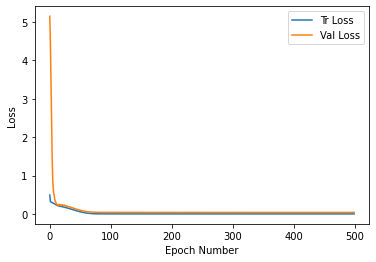

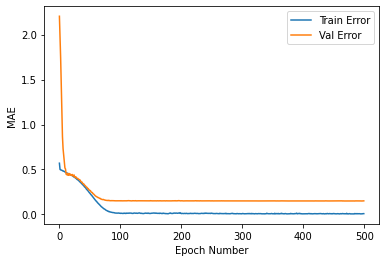

In [9]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()

In [10]:
test_x[0].shape
test_sample=torch.unsqueeze(test_x[0],0).to(device)

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])